# Poisoning using the BadNet Regional Misclassification Attack in ART

This notebook shows how to use the BadNet Regional Misclassification Attack (RMA) to create image backdoors in the training data for object detector models such as Faster R-CNN or YOLO. 

In [1]:
import requests
import os
import sys
from io import BytesIO
from PIL import Image

import numpy as np
import matplotlib.pyplot as plt
import cv2

from art.estimators.object_detection import PyTorchFasterRCNN
from art.attacks.poisoning import PoisoningAttackBackdoor, BadDetRegionalMisclassificationAttack
from art.attacks.poisoning.perturbations import insert_image

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

## Constants and Utility Functions

Some constants and utility functions that will be used in this demo.

In [2]:
COCO_INSTANCE_CATEGORY_NAMES = [
    "__background__",
    "person",
    "bicycle",
    "car",
    "motorcycle",
    "airplane",
    "bus",
    "train",
    "truck",
    "boat",
    "traffic light",
    "fire hydrant",
    "N/A",
    "stop sign",
    "parking meter",
    "bench",
    "bird",
    "cat",
    "dog",
    "horse",
    "sheep",
    "cow",
    "elephant",
    "bear",
    "zebra",
    "giraffe",
    "N/A",
    "backpack",
    "umbrella",
    "N/A",
    "N/A",
    "handbag",
    "tie",
    "suitcase",
    "frisbee",
    "skis",
    "snowboard",
    "sports ball",
    "kite",
    "baseball bat",
    "baseball glove",
    "skateboard",
    "surfboard",
    "tennis racket",
    "bottle",
    "N/A",
    "wine glass",
    "cup",
    "fork",
    "knife",
    "spoon",
    "bowl",
    "banana",
    "apple",
    "sandwich",
    "orange",
    "broccoli",
    "carrot",
    "hot dog",
    "pizza",
    "donut",
    "cake",
    "chair",
    "couch",
    "potted plant",
    "bed",
    "N/A",
    "dining table",
    "N/A",
    "N/A",
    "toilet",
    "N/A",
    "tv",
    "laptop",
    "mouse",
    "remote",
    "keyboard",
    "cell phone",
    "microwave",
    "oven",
    "toaster",
    "sink",
    "refrigerator",
    "N/A",
    "book",
    "clock",
    "vase",
    "scissors",
    "teddy bear",
    "hair drier",
    "toothbrush",
]

In [3]:
def load_images_from_urls(urls, size):
    images = []
    for url in urls:
        response = requests.get(url)
        image = np.asarray(Image.open(BytesIO(response.content)))
        image = (image / 255).astype(np.float32)
        image = cv2.resize(image, dsize=size, interpolation=cv2.INTER_AREA)
        images.append(image)
    images = np.asarray(images)
    return images


def threshold_predictions(predictions, threshold):
    boxes = predictions['boxes']
    labels = predictions['labels']
    scores = predictions['scores']

    mask = scores >= threshold
    result_dict = {
        'boxes': boxes[mask],
        'labels': labels[mask],
        'scores': scores[mask],
    }

    return result_dict


def plot_image_with_boxes(img, predictions=None):
    text_size = 1
    text_th = 2
    rect_th = 2

    img = (img * 255).astype(np.uint8)

    if predictions is not None:
        boxes = predictions['boxes'].astype(int)
        labels = predictions['labels']

        # for i in range(len(boxes)):
        for box, label in zip(boxes, labels):
            # Draw Rectangle with the coordinates
            cv2.rectangle(img, (box[0], box[1]), (box[2], box[3]), color=(0, 255, 0), thickness=rect_th)

            # Write the prediction class
            text = COCO_INSTANCE_CATEGORY_NAMES[label]
            cv2.putText(img, text, (box[0], box[1]), cv2.FONT_HERSHEY_SIMPLEX, text_size, (255, 0, 0), thickness=text_th)

    plt.axis("off")
    plt.imshow(img.astype(np.uint8), interpolation="nearest")
    plt.show()

## Load Data

### Images

We will be using two sample images from the dataset used by Ultralytics to train YOLO.

float32 (2, 480, 480, 3)


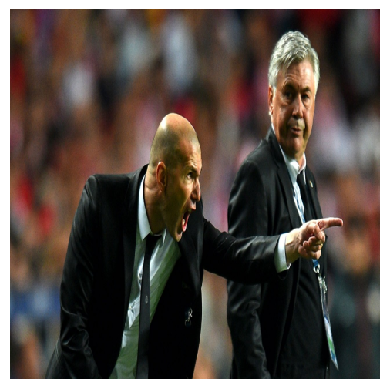

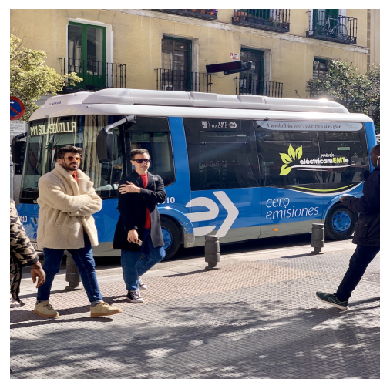

In [4]:
urls = [
    'https://ultralytics.com/images/zidane.jpg',
    'https://ultralytics.com/images/bus.jpg',
]

x = load_images_from_urls(urls, size=(480, 480))

print(x.dtype, x.shape)
plot_image_with_boxes(x[0], predictions=None)
plot_image_with_boxes(x[1], predictions=None)

### Labels

To get the labels for the bounding boxes and classifications, we will be using a pre-trained Faster R-CNN classifier to run predictions on the images. For this demo, we will be using these predictions as the ground truth.

In [5]:
frcnn = PyTorchFasterRCNN(
    clip_values=(0, 1), attack_losses=["loss_classifier", "loss_box_reg", "loss_objectness", "loss_rpn_box_reg"]
)

/usr/local/anaconda3/envs/art/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/usr/local/anaconda3/envs/art/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/anaconda3/envs/art/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained_backbone' is deprecated since 0.13 and will be removed in 0.15, please use 'weights_backbone' instead.
  warnings.warn(
/usr/local/anaconda3/envs/art/lib/python3.8/site-packages/torchvision/models

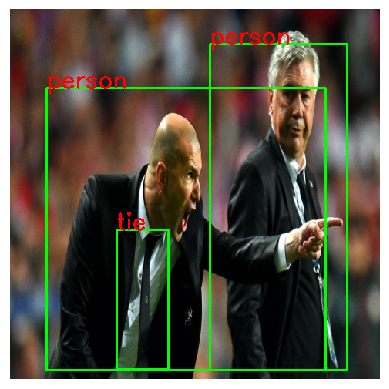

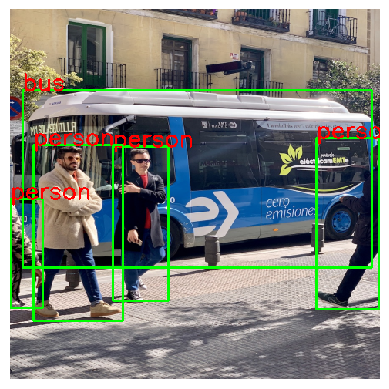

In [6]:
preds = frcnn.predict(x=x)
y = [threshold_predictions(pred, 0.9) for pred in preds]

plot_image_with_boxes(x[0], y[0])
plot_image_with_boxes(x[1], y[1])

## Insert Backdoor

### Backdoor Trigger

We will be using the HTBD backdoor trigger.

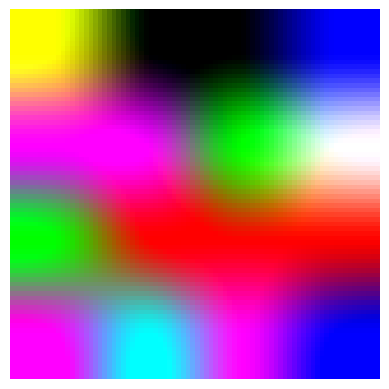

In [7]:
trigger_path = '../utils/data/backdoors/htbd.png'

trigger = np.asarray(Image.open(trigger_path)) / 255
plot_image_with_boxes(trigger, predictions=None)

### Backdoor Object

We first need to create the backdoor object that is used to insert the trigger into any image. We will always be inserting the trigger into the top left corner.

In [8]:
def poison_func(x):
    return insert_image(x, backdoor_path=trigger_path, size=(29, 29), mode='RGB', blend=0.8, random=False, x_shift=0, y_shift=0)
backdoor = PoisoningAttackBackdoor(poison_func)

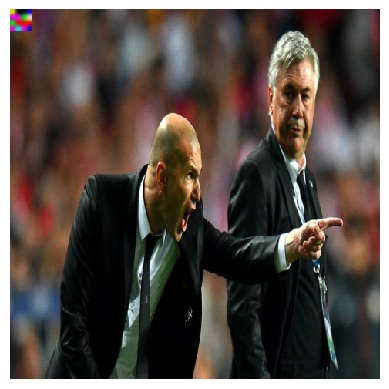

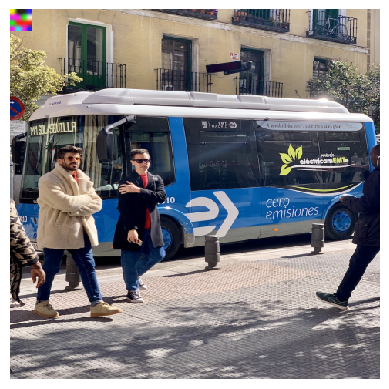

In [9]:
x_poisoned, _ = backdoor.poison(x, [])
plot_image_with_boxes(x_poisoned[0], predictions=None)
plot_image_with_boxes(x_poisoned[1], predictions=None)

### BadDet Regional Misclassification Attack

Now that we have the backdoor object, we can perform the BadNet Regional Misclassification Attack. We will poison class 1 (person) into class 2 (bicycle) for 100% of the images. This attack will insert the trigger into the bounding box region of the image and change the classification label accordingly.

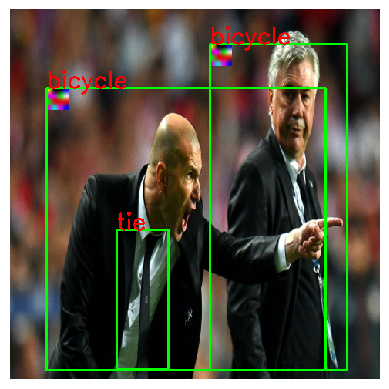

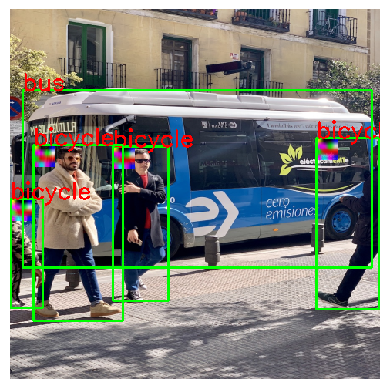

In [10]:
attack = BadDetRegionalMisclassificationAttack(backdoor, class_source=1, class_target=2, percent_poison=1.0)
x_poisoned, y_poisoned = attack.poison(x, y)

plot_image_with_boxes(x_poisoned[0], y_poisoned[0])
plot_image_with_boxes(x_poisoned[1], y_poisoned[1])

## Train Using Poisoned Data

Using the poisoned data, train the Faster R-CNN or YOLO classifier.